In [26]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from astropy.io import fits
%matplotlib inline

In [85]:
agemodel = ppy.agemodels.NonParam()
agemodel.update_edges(np.array([6.0, 8.0, 9.0, 9.5, 10.0, 10.2]))

tau_model = ppy.agemodels.TauModel(iso_step=-1)
tau_model.iso_edges = np.array([6.0, 8.0, 9.0, 9.5, 10.0, 10.2])
tau_model.set_params(np.array([2.258, 2.8205]))

tau_SFH = list(np.log10(tau_model.SFH))

gal_np = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    agemodel,
    ppy.distancemodels.VariableDistance()
)
gal_np.set_params(np.array([0.1676, -1.8033] + tau_SFH + [24.42]))

gal_nomu = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    agemodel,
    ppy.distancemodels.FixedDistance(24.42)
)
gal_nomu.set_params(np.array([0.1676, -1.8033] + tau_SFH))

In [86]:
res = {}
m31_regions = [1, 2]
m31_names = {1: 'Bulge', 2: 'Disk'}
for r in [1, 2]:
    try:
        res['m{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_tau_r{:d}.csv'.format(r),
                                                            run_name='M31 {:s}'.format(m31_names[r]))
        res['m{:d}_nm'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_taunomu_r{:d}.csv'.format(r),
                                                            run_name='M31 {:s} (Distance Fixed)'.format(m31_names[r]))
    except:
        print('m{:d} not found'.format(r))        
for r in [1, 2]:
    try:
        res['n{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_tau_narrow_r{:d}.csv'.format(r),
                                                            run_name='M31 {:s} - Narrow Range'.format(m31_names[r]))
        res['n{:d}_nm'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_taunomu_narrow_r{:d}.csv'.format(r),
                                                            run_name='M31 {:s} - Narrow Range (Distance Fixed)'.format(m31_names[r]))
    except:
        print('n{:d} not found'.format(r))        
for r in [1, 2]:
    try:
        res['1024_{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_tau_narrow_1024_r{:d}.csv'.format(r),
                                                            run_name='M31 {:s} (Nim = 1024)'.format(m31_names[r]))
    except:
        print('1024_{:d} not found'.format(r))        
        
for r in [1]:
    res['np{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_nonparam_r{:d}.csv'.format(r), true_model=gal_np, 
                                                        run_name='M31 {:s} Nonparam'.format(m31_names[r]))
    res['np{:d}_nm'.format(r)] = ppy.plotting.ResultsPlotter('results/m31_nonparam_nomu_r{:d}.csv'.format(r), true_model=gal_nomu,
                                                        run_name='M31 {:s} Nonparam (Distance Fixed)'.format(m31_names[r]))

In [87]:
dmod_m31 = 24.42
xmax = np.max([len(r.df) for r in res.values()])
print(xmax)

11769


In [88]:
for k, v in res.items():
    if '_nm' in k:
        v.df['dmod'] = dmod_m31

In [93]:
def plot_sets(run_names, regions=[1,2], chains_only=False, dmod_true=24.42, nonparam=False):
    if chains_only:
        nr = 5
    else:
        nr = 8
    if nonparam:
        nr += 4
    nx = len(run_names)
    fs = (10+5*nx, 3*nr)
    fig, axes = plt.subplots(ncols=len(run_names)*len(regions), nrows=nr, figsize=fs, sharex=True, sharey='row')
    for i, r in enumerate(regions):
        for j, n in enumerate(run_names):
            plot_axes = axes[:, nx*i + j]
            if '_nm' in n:
                if nonparam:
                    plot_axes = list(plot_axes[:7])+list(plot_axes[8:])
                else:
                    plot_axes = list(plot_axes[:3])+list(plot_axes[4:])
            res[n.format(r)].plot_chains(axes=plot_axes, chains_only=chains_only)
    if not nonparam:
        for ax in axes[3]:
            ax.axhline(y=dmod_true, ls='--', color='r')
    plt.tight_layout()
    return fig, axes

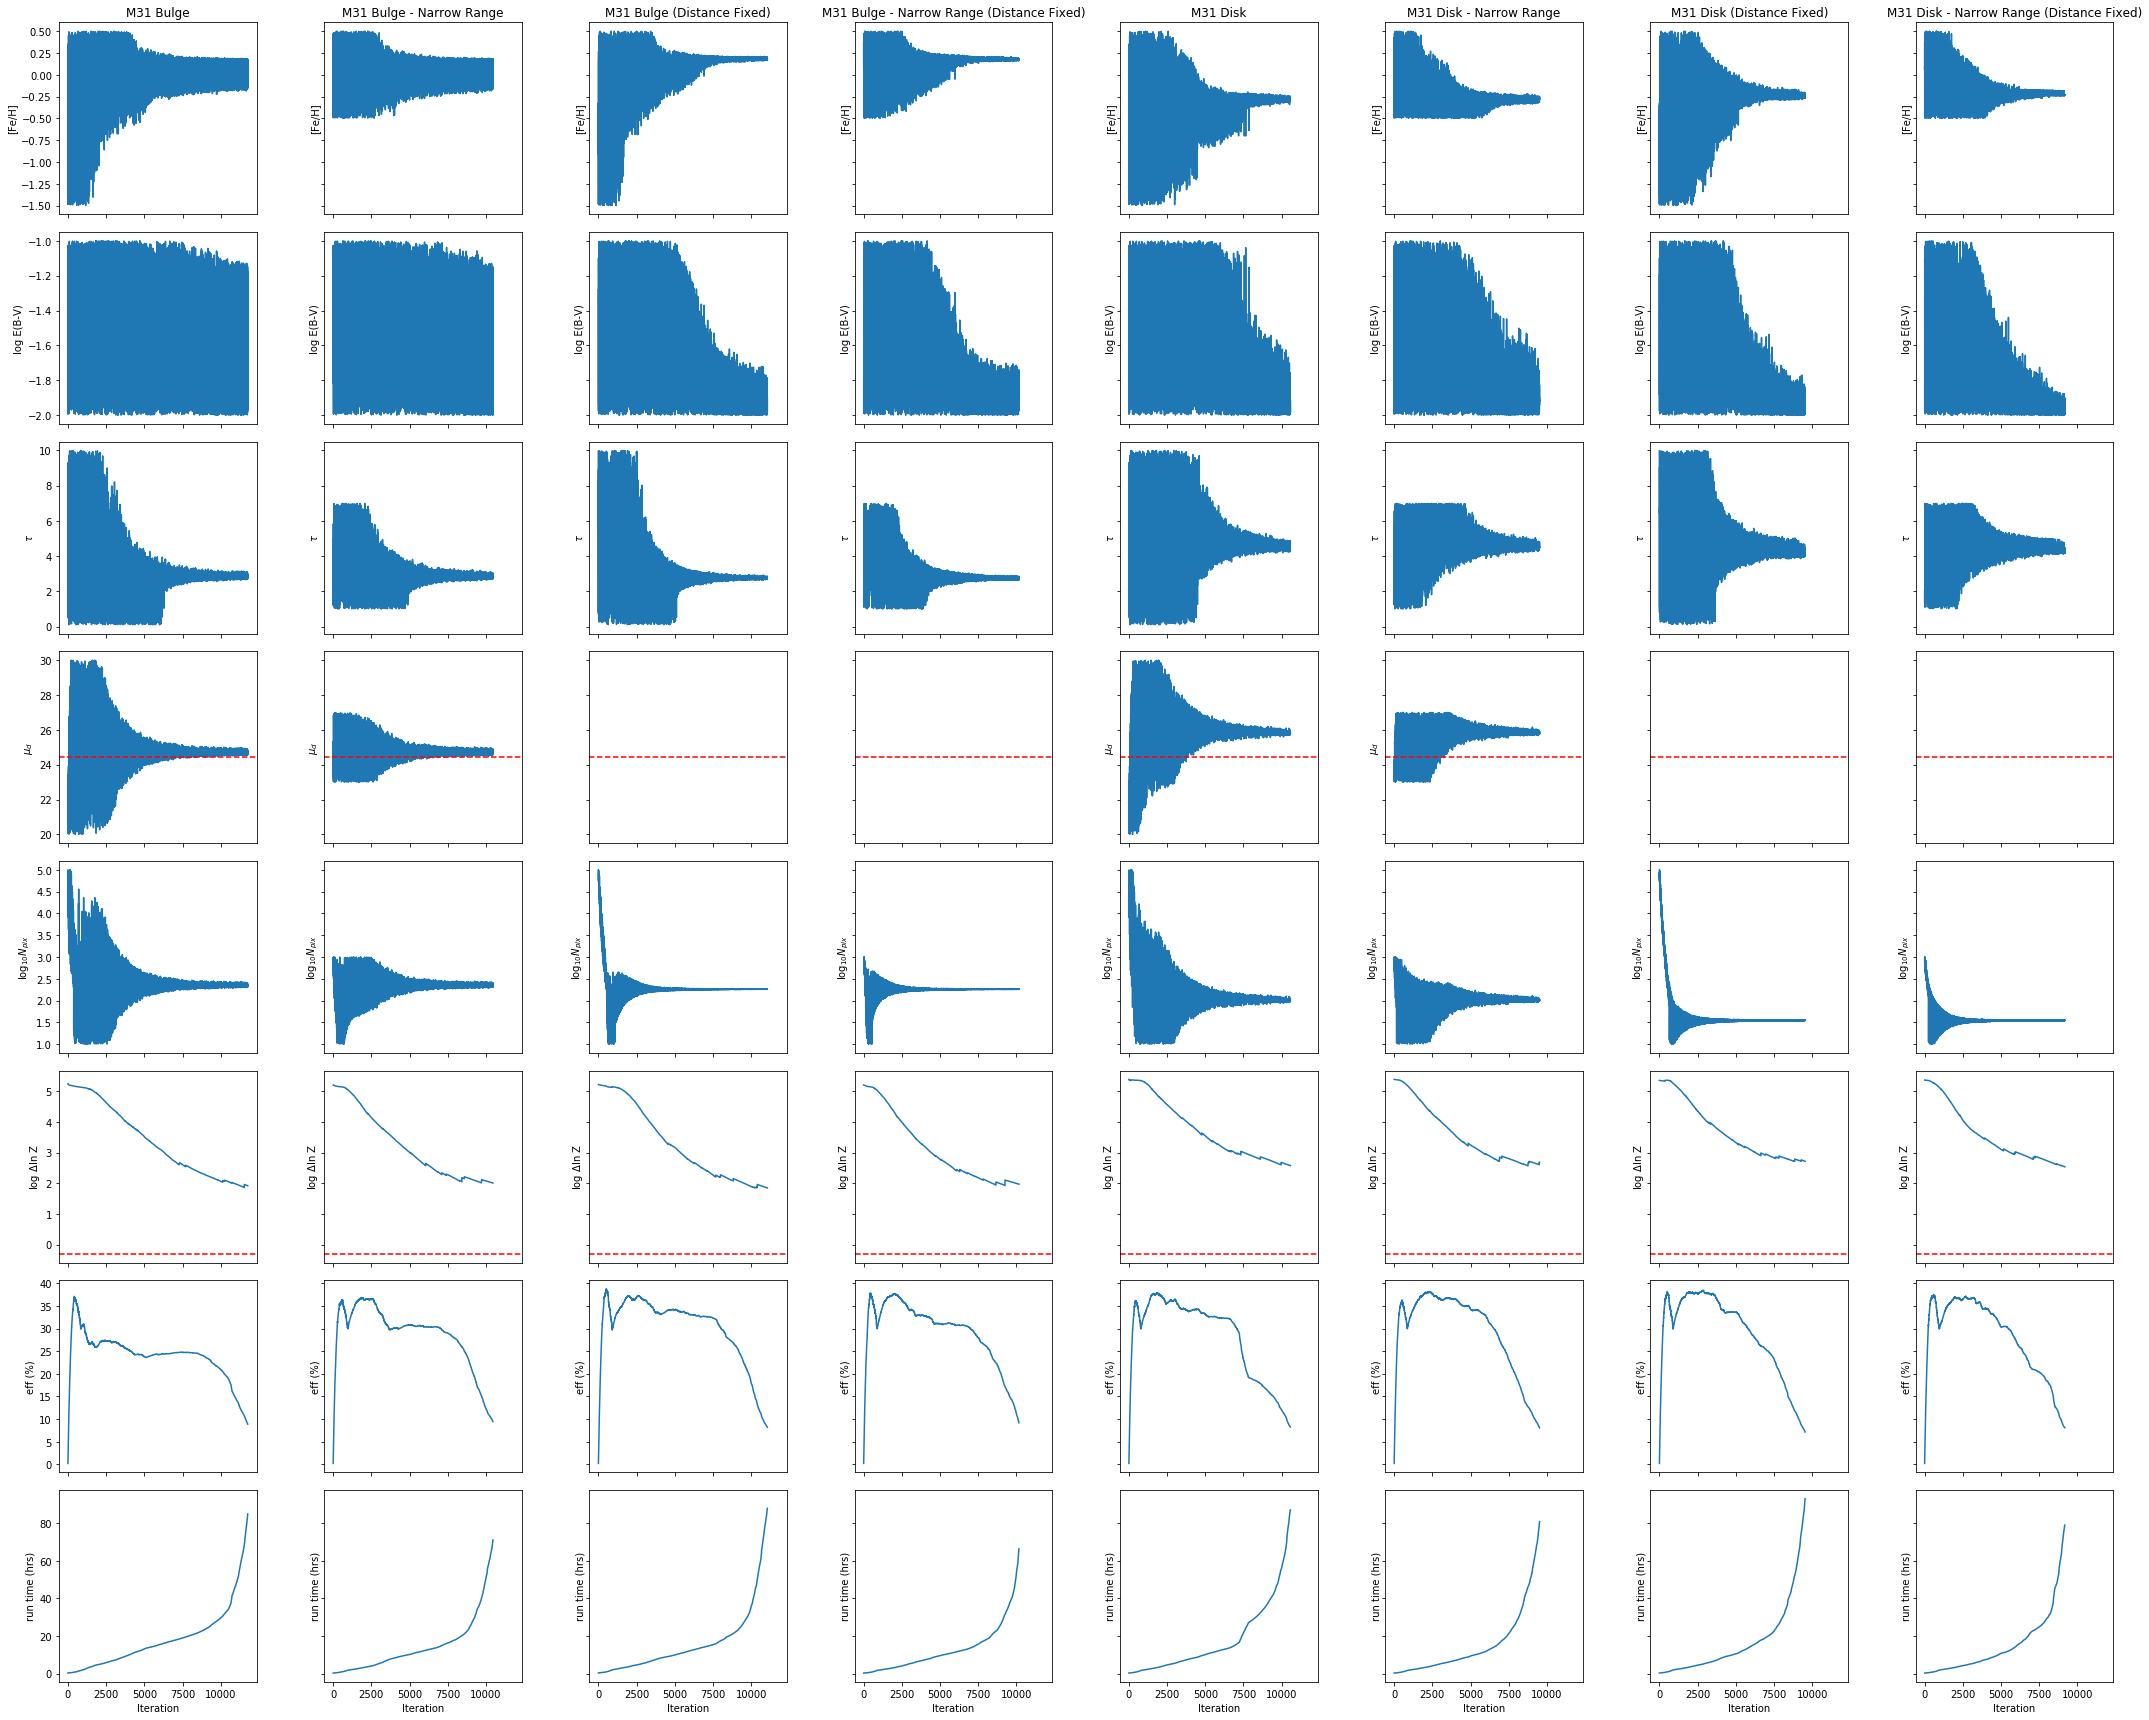

In [91]:
fig, axes = plot_sets(['m{:d}', 'n{:d}', 'm{:d}_nm', 'n{:d}_nm'], chains_only=False)

In [79]:
res['n1_nm'].df.tail(1)[['logfeh_mean', 'logdust', 'logNpix', 'tau']]

logfeh_mean  logdust  logNpix     tau
10168       0.1676  -1.8033    2.258  2.8205

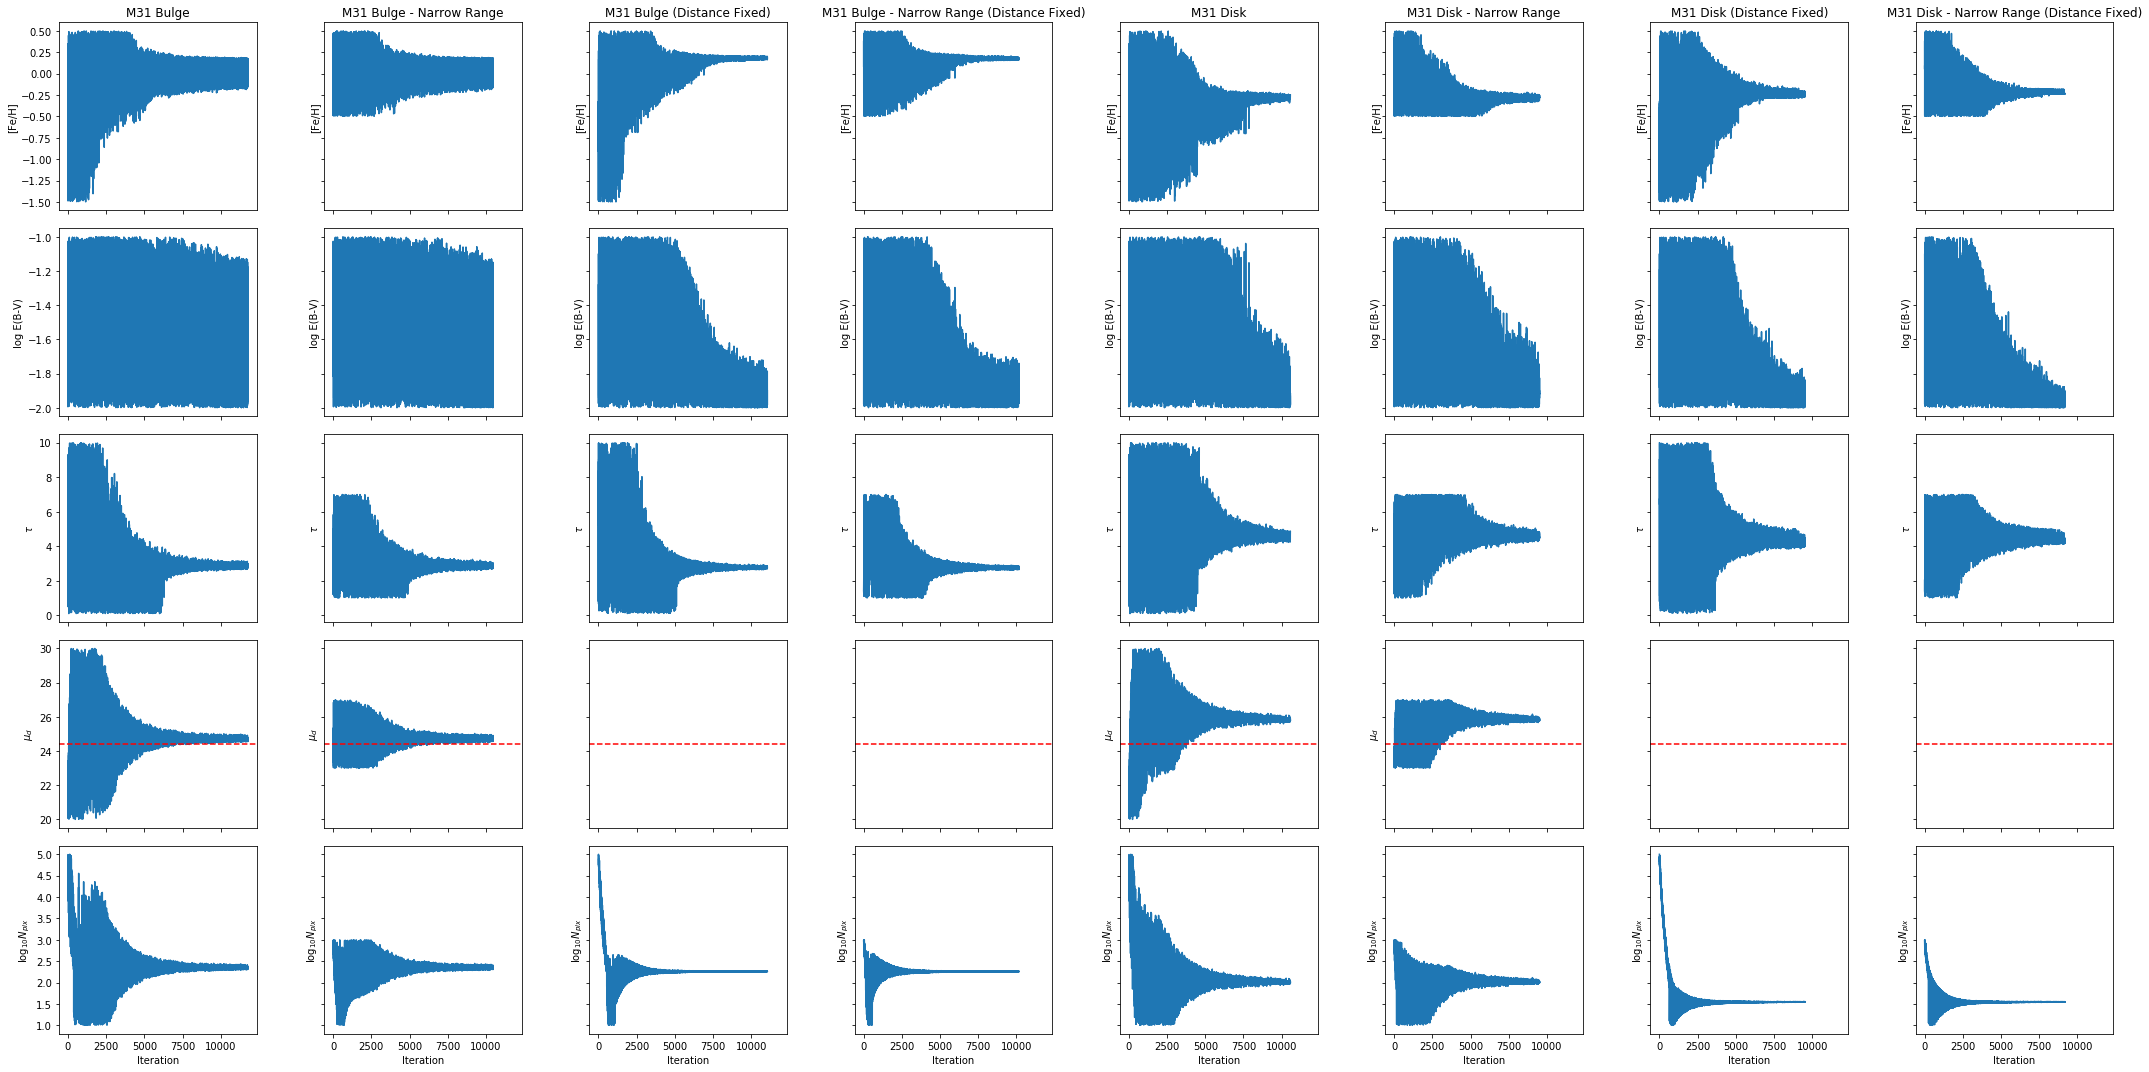

In [49]:
fig, axes = plot_sets(['m{:d}', 'n{:d}', 'm{:d}_nm', 'n{:d}_nm'], chains_only=True)

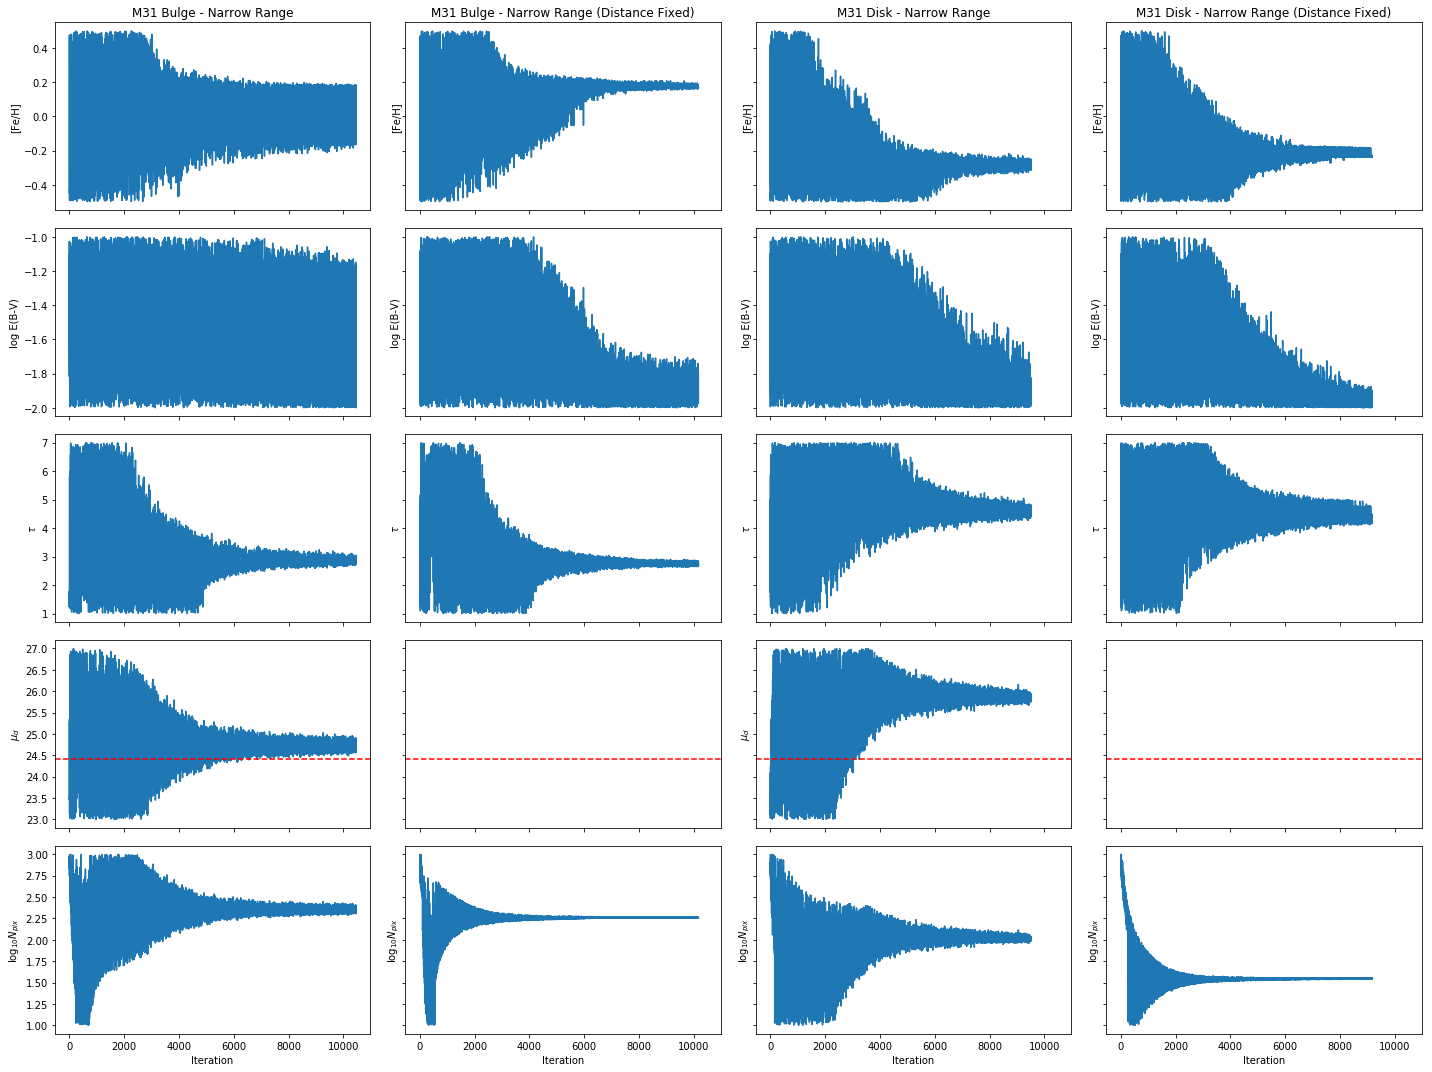

In [50]:
fig, axes = plot_sets(['n{:d}', 'n{:d}_nm'], chains_only=True)

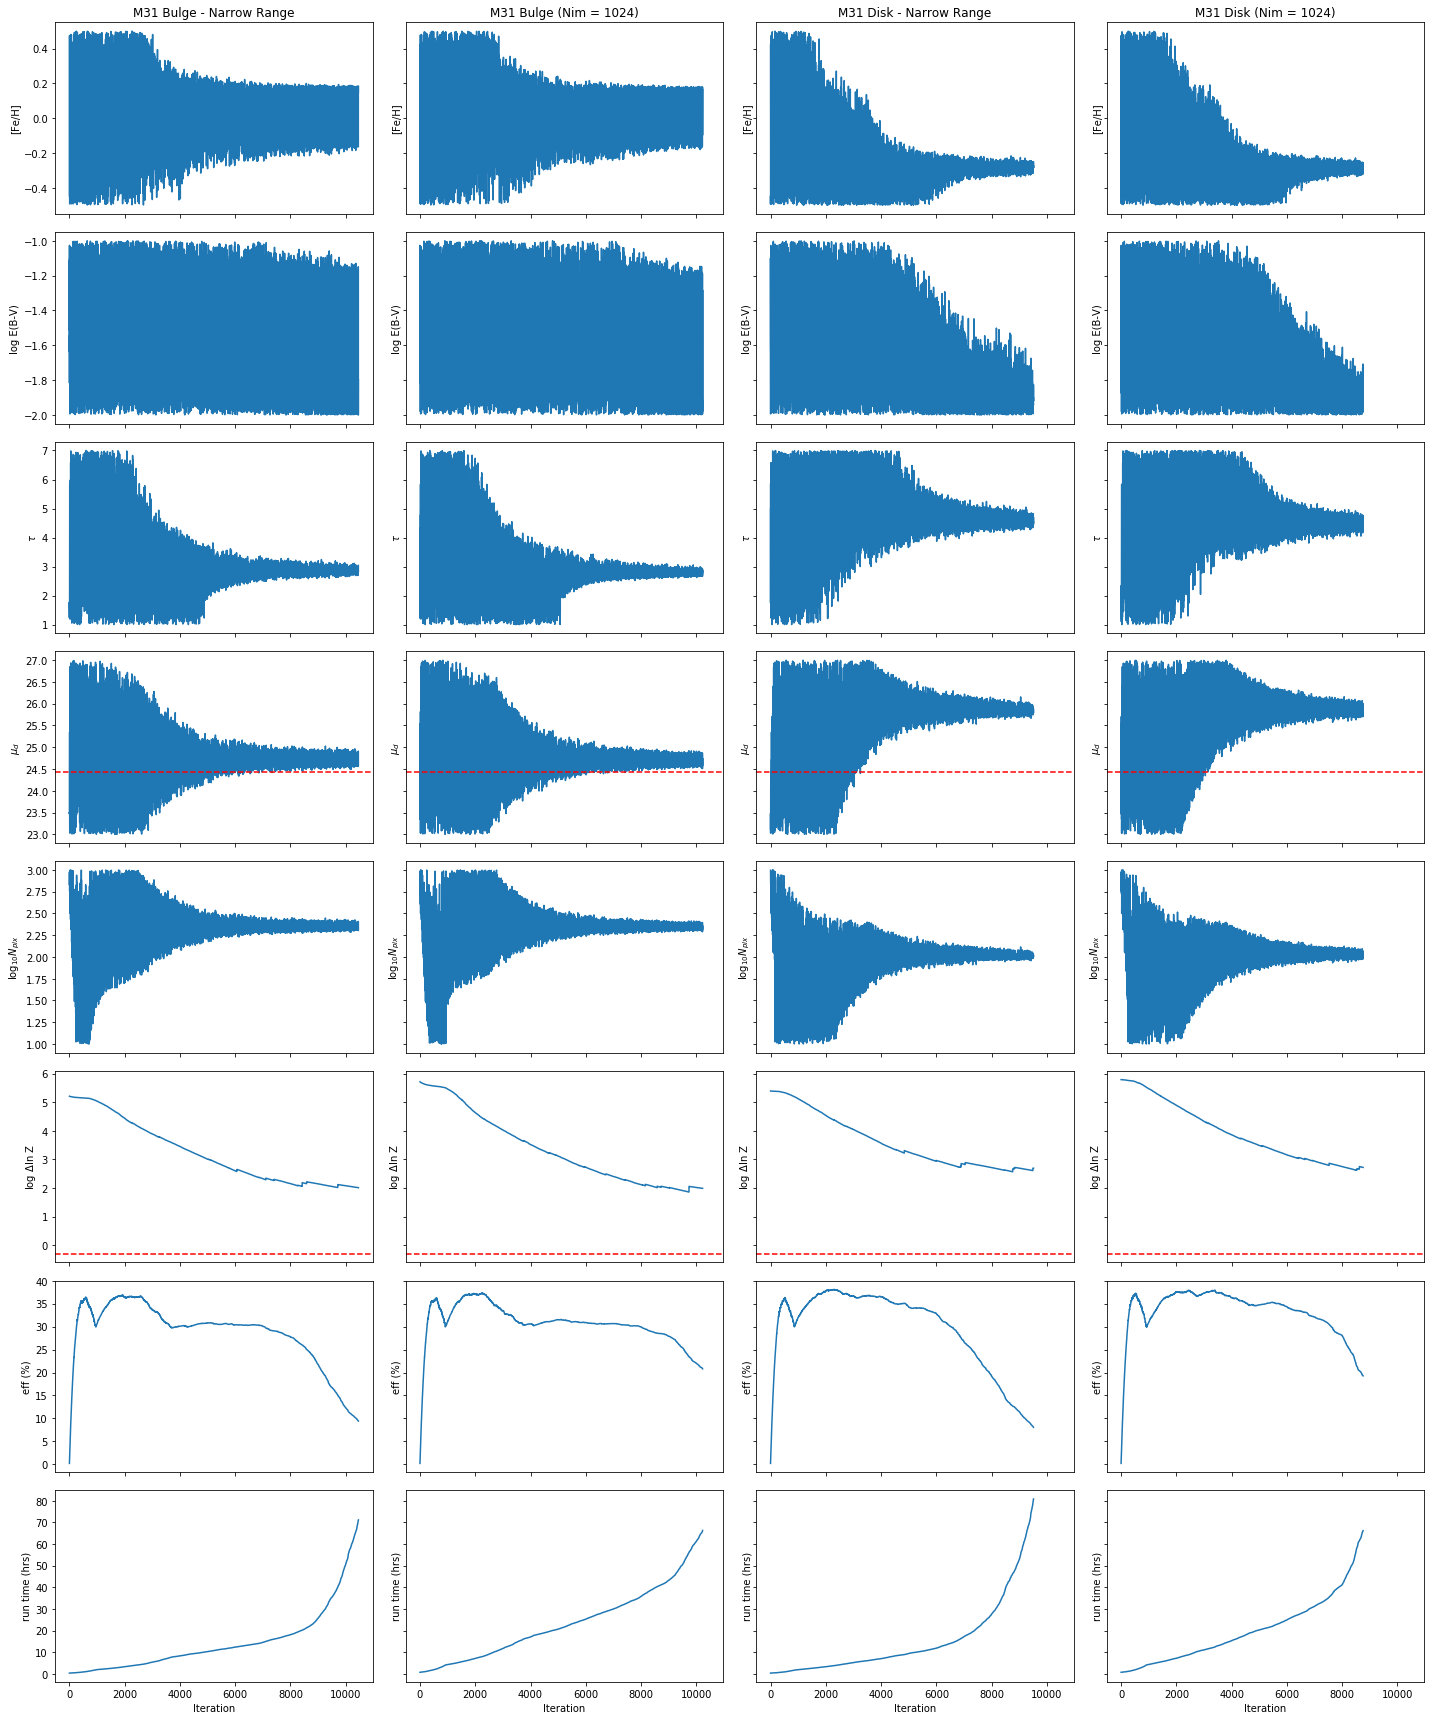

In [52]:
fig, axes = plot_sets(['n{:d}', '1024_{:d}'], chains_only=False)

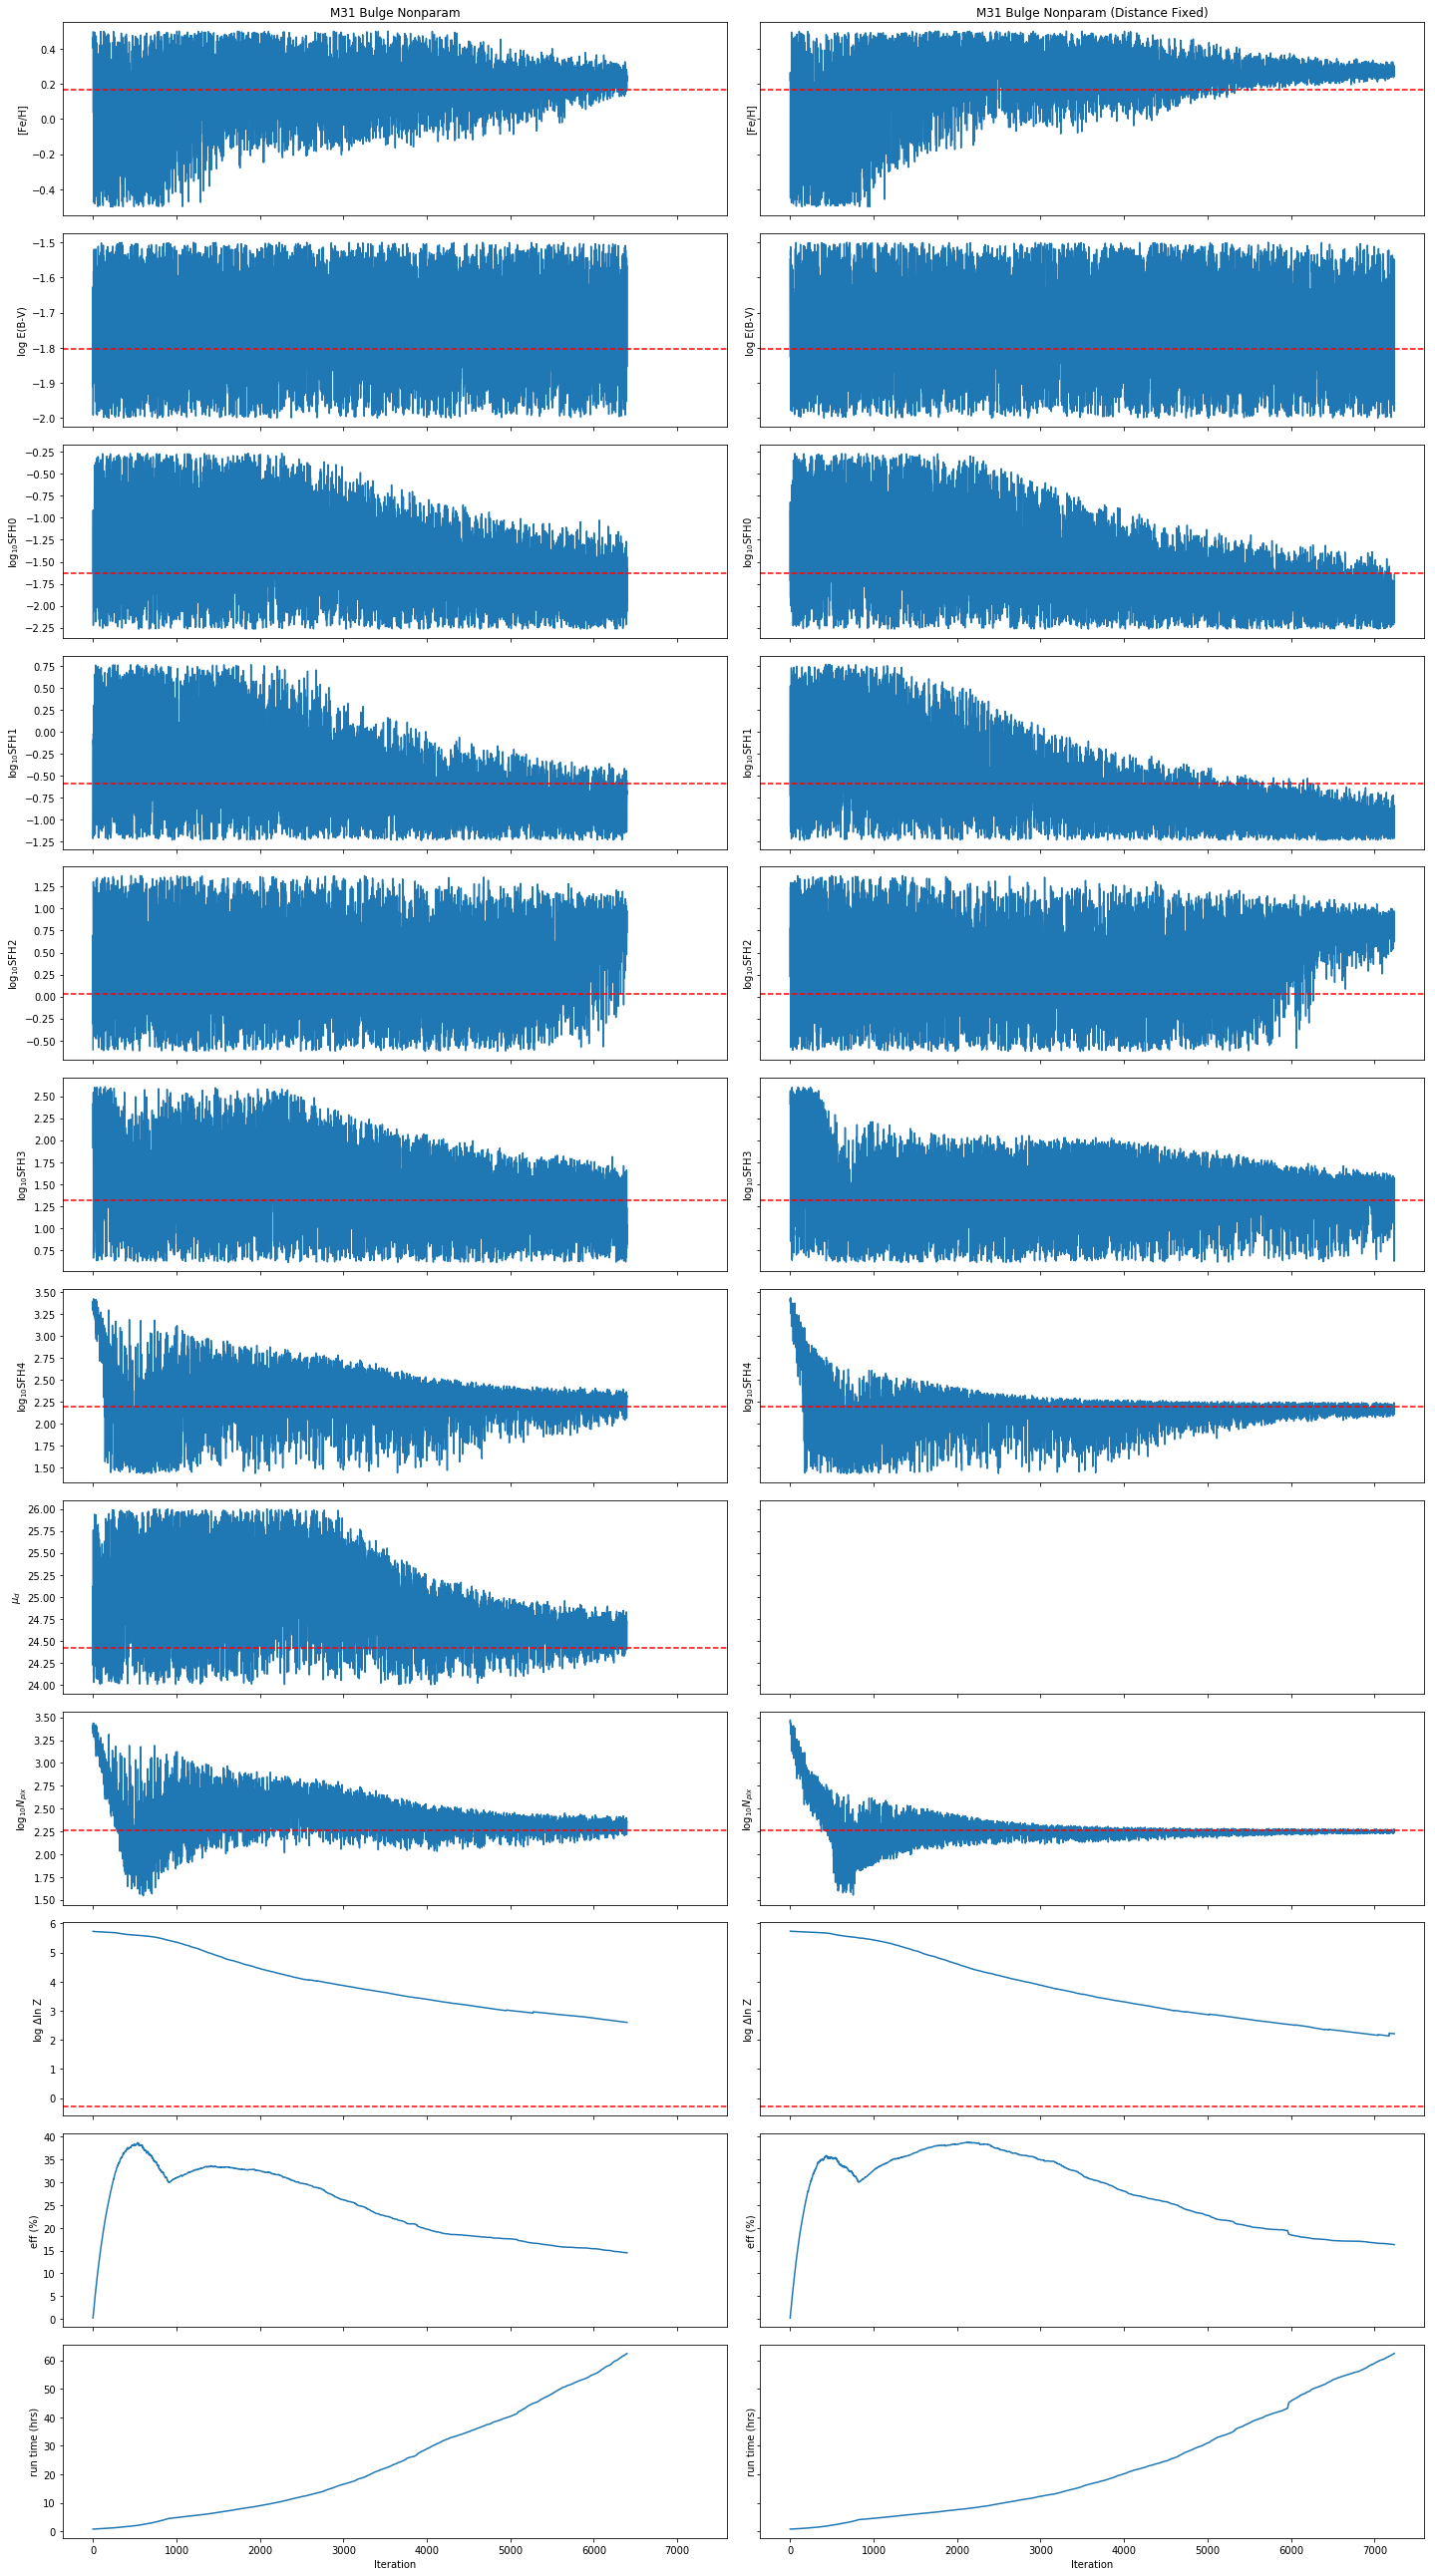

In [94]:
fig, axes = plot_sets(['np{:d}', 'np{:d}_nm'], regions=[1], chains_only=False, nonparam=True)

In [122]:
def plot_dmod(axes, dmod=24.42):
    i_dmod = 3
    for i, ax in enumerate(axes[0]):
        if 'mu' in ax.get_ylim():
            i_dmod = i
    for ax in axes[i_dmod, :i_dmod]:
        ax.axhline(y=24.42, ls='--', color='r')
    for ax in axes[i_dmod:, i_dmod]:
        ax.axvline(x=24.42, ls='--', color='r')

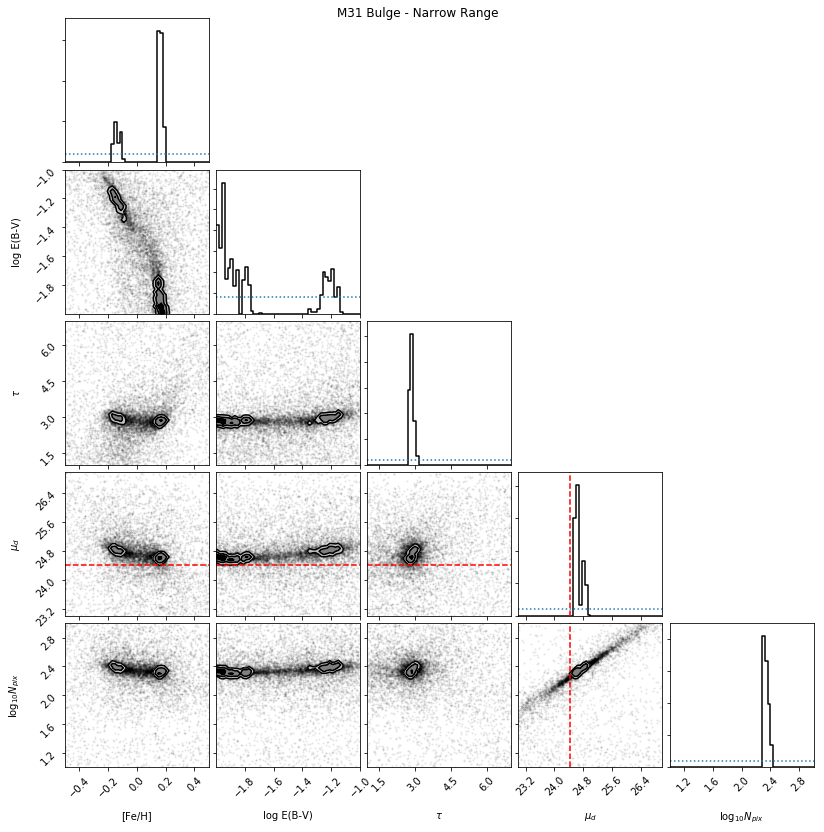

In [123]:
fig, axes = res['n1'].plot_corner(bins=50, weight=True);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_narrow_weighted.pdf')

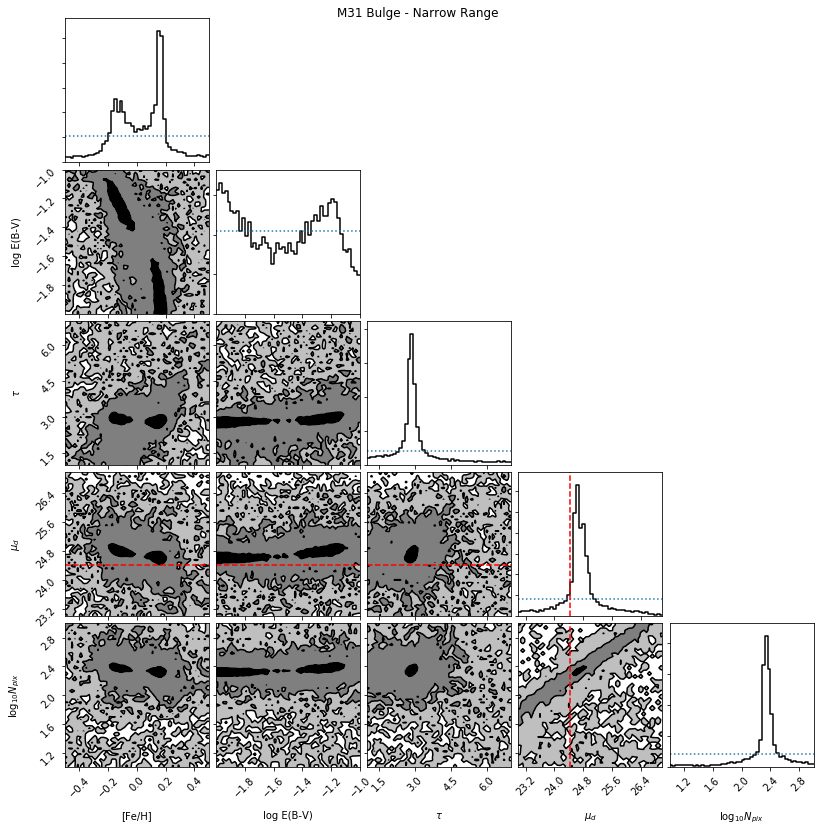

In [124]:
fig, axes = res['n1'].plot_corner(bins=50, weight=False);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_narrow.pdf')

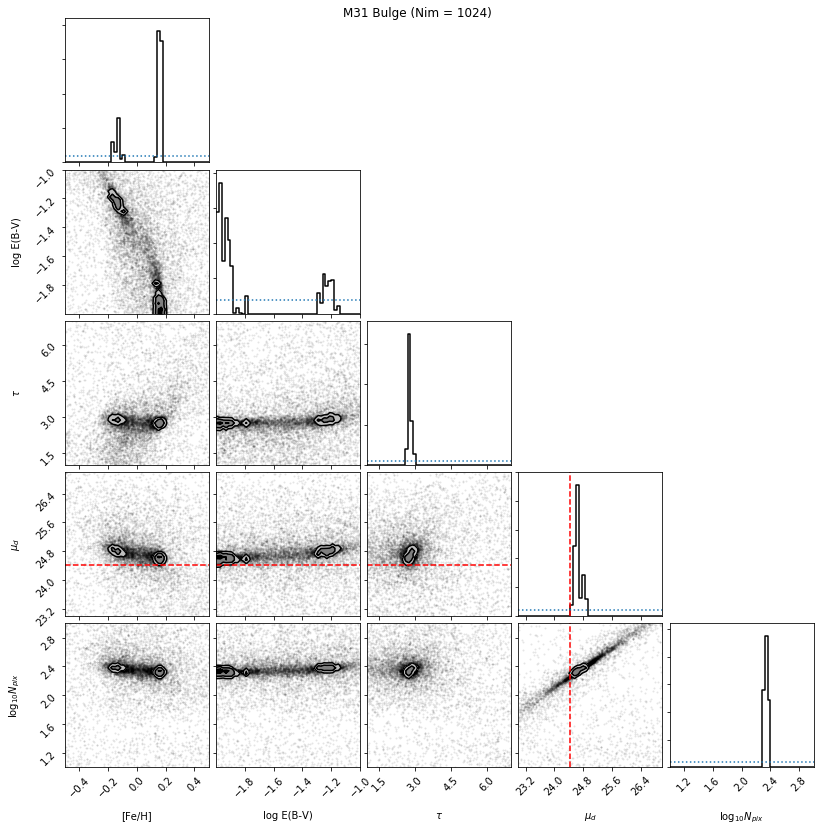

In [125]:
fig, axes = res['1024_1'].plot_corner(bins=50, weight=True);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_1024_weighted.pdf')

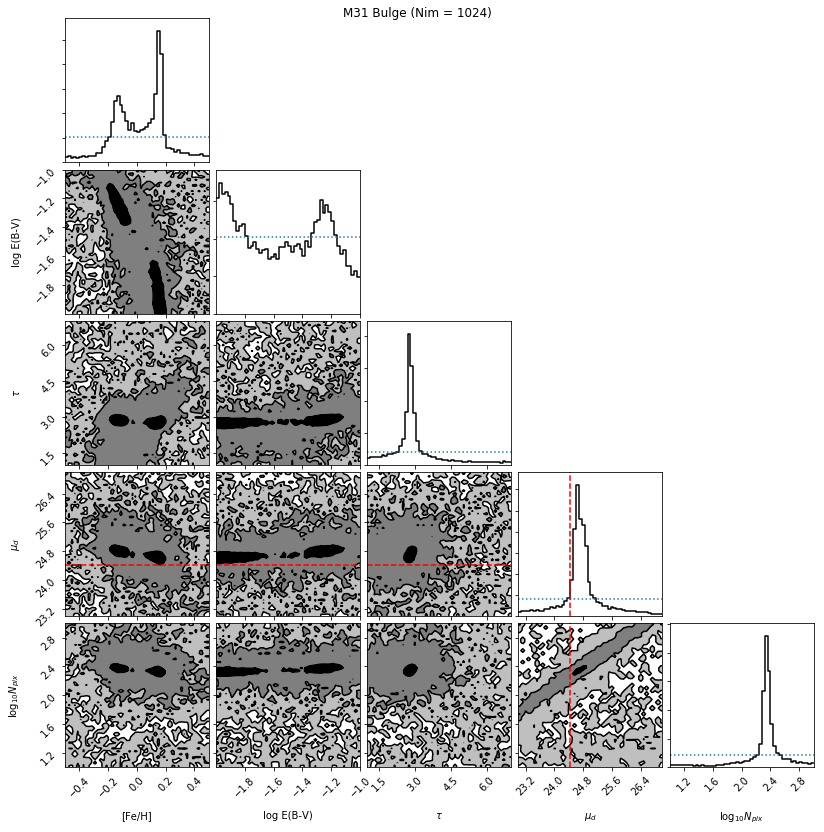

In [126]:
fig, axes = res['1024_1'].plot_corner(bins=50, weight=False);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_1024.pdf')

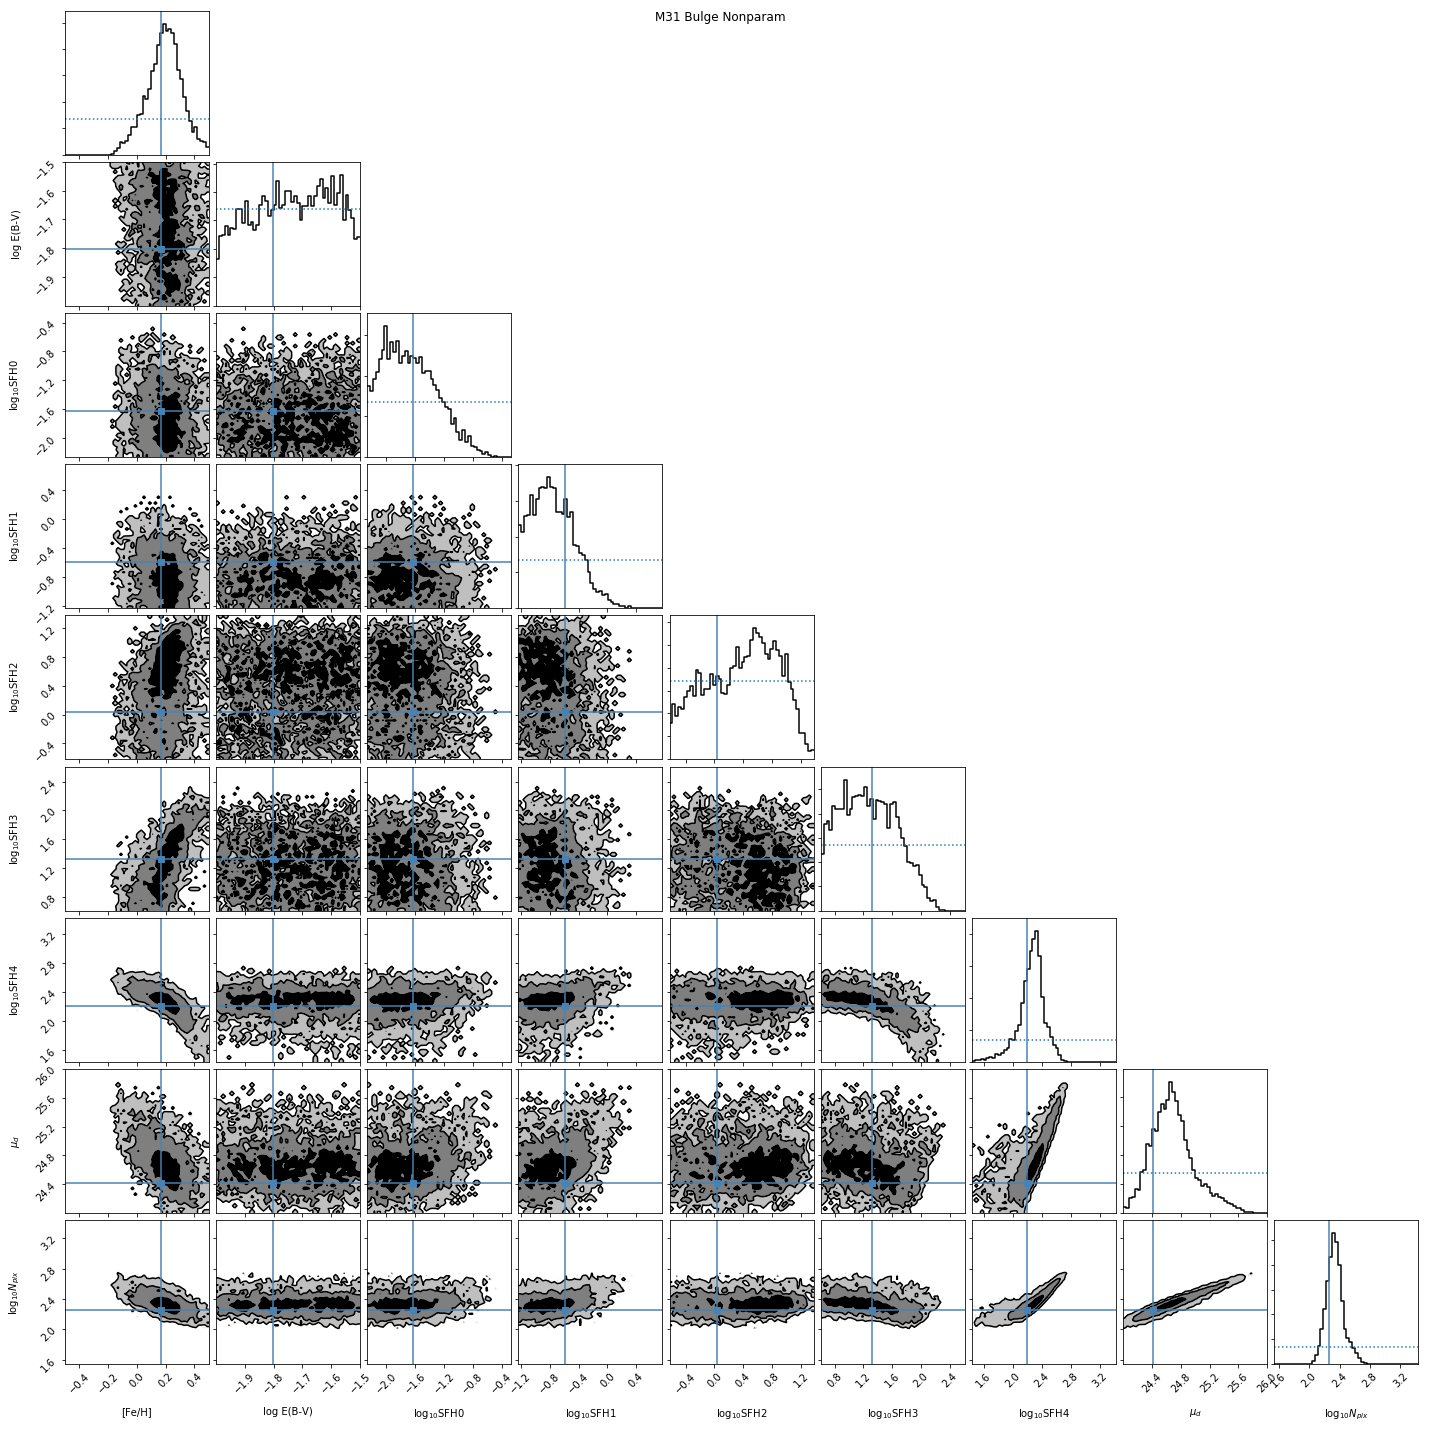

In [127]:
fig, axes = res['np1'].plot_corner(bins=50, weight=False, burn=3000);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_nonparam.pdf')

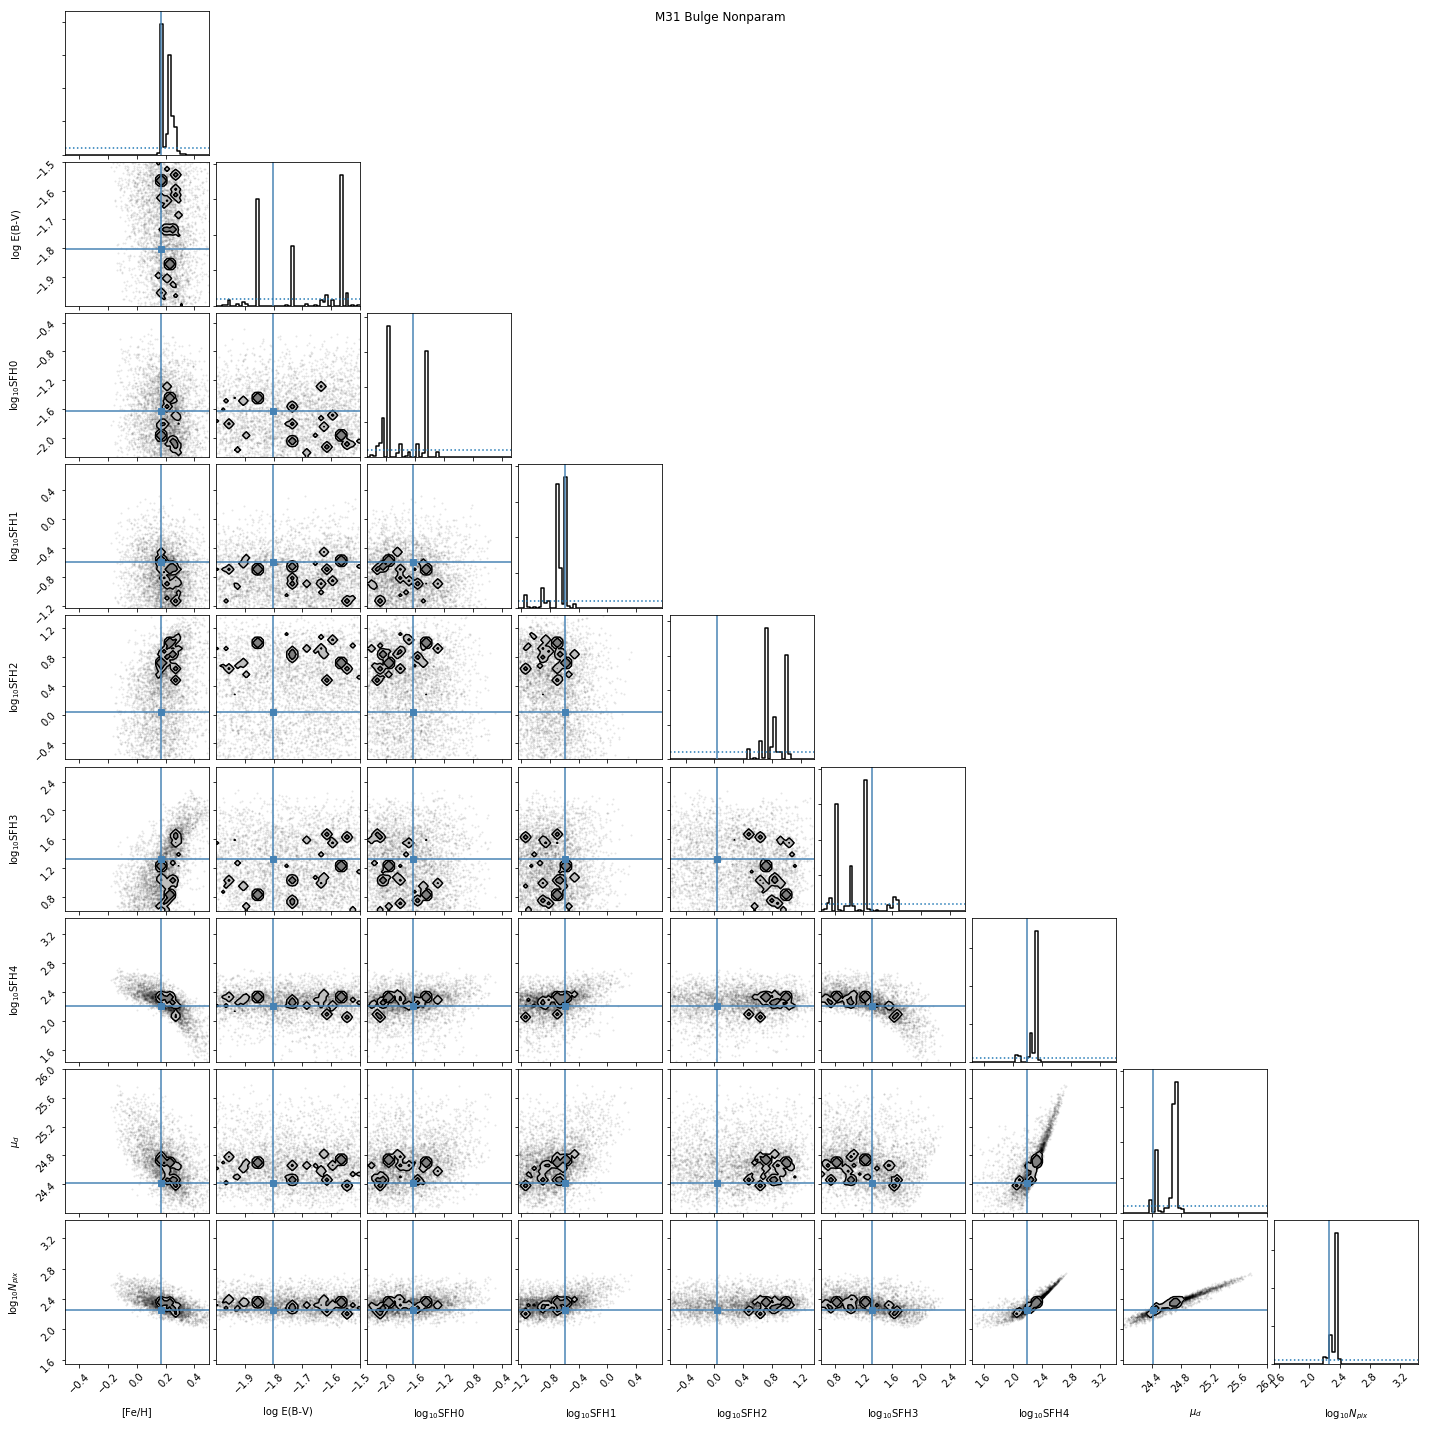

In [131]:
fig, axes = res['np1'].plot_corner(bins=50, weight=True, burn=3000);
plot_dmod(axes)
plt.savefig('figures/m31_bulge_corner_nonparam_weighted.pdf')

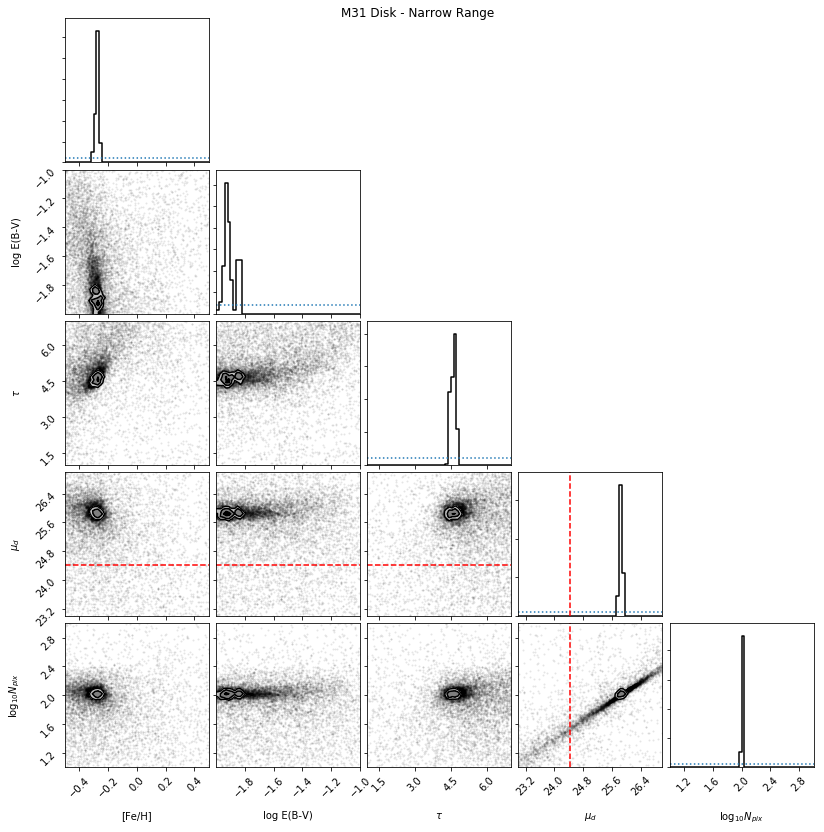

In [129]:
fig, axes = res['n2'].plot_corner(bins=50, weight=True);
plot_dmod(axes)
plt.savefig('figures/m31_disk_corner_narrow_weighted.pdf')

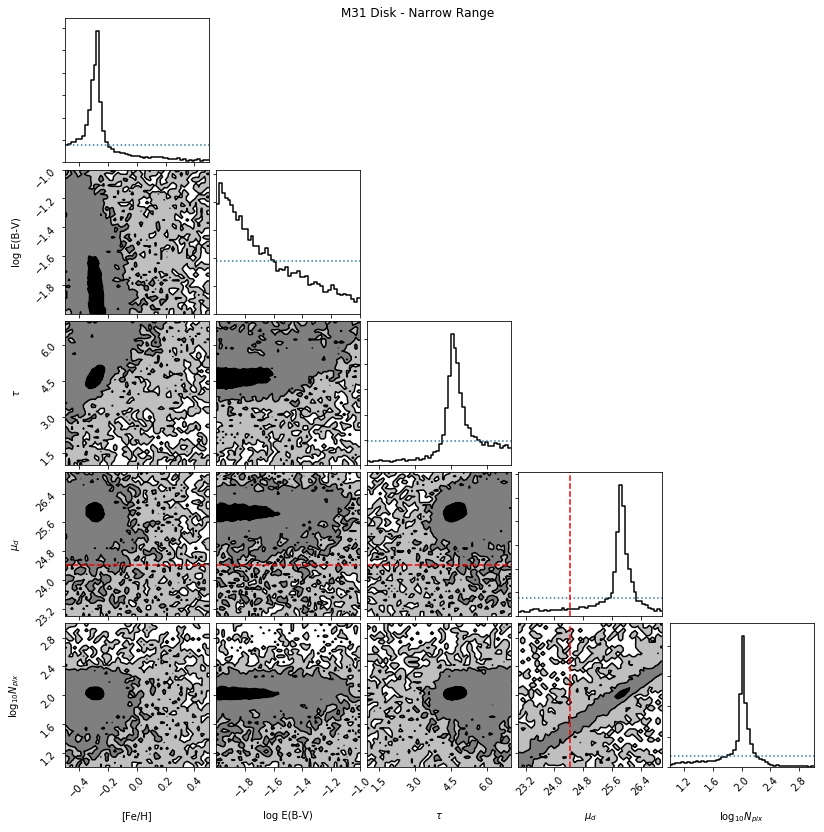

In [130]:
fig, axes = res['n2'].plot_corner(bins=50, weight=False);
plot_dmod(axes)
plt.savefig('figures/m31_disk_corner_narrow_weighted.pdf')